<h1 style="background-color:#0071BD;color:white;text-align:center;padding-top:0.8em;padding-bottom: 0.8em">
    Frank-Wolfe for Minimum Enclosing Balls
</h1>

Accompanying notebook for two lecture notes on Machine Learning:

  * Christian Bauckhage and Tiansi Dong: "Minimum Enclosing Balls", B-IT, University of Bonn, February 2019 ([Download from ResearchGate](https://www.researchgate.net/publication/331152293_Lecture_Notes_on_Machine_Learning_Minimum_Enclosing_Balls))
  * Abstract of the paper: *The minimum enclosing ball problem is another example of a problem that can be cast as a constrained convex optimization problem. It thus provides us with another opportunity to work with the Karush-Kuhn-Tucker (KKT) conditions and to derive a Lagrangian dual which, as we shall see later, allows for a simple solution for the problem.* 

  * Christian Bauckhage and Tiansi Dong: "Frank-Wolfe for Minimum Enclosing Balls", B-IT, University of Bonn, February 2019 ([Download from ResearchGate](https://www.researchgate.net/publication/331315423_Lecture_Notes_on_Machine_Learning_Frank-Wolfe_for_Minimum_Enclosing_Balls))
  * Abstract of the paper: *In  this  note,  we  show  how  the  Frank-Wolfe  algorithm  applies  to  the problem of computing the minimum enclosing ball of a set of data.*

<p style="background-color:#66A5D1;padding-top:0.2em;padding-bottom: 0.2em" />

In [1]:
import numpy as np
import numpy.random as rnd

import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from mpl_toolkits.mplot3d import Axes3D

from functools import partial

## Plotting utilities

In [2]:
blu = '#0059ff' # hsv(219., 1., 1. ); // blue 
ora = '#ffa500' # hsv( 39., 1., 1. ); // orange

alpha_now = 1.0
alpha_old = 0.2

def plot_points(axs, X):
    axs.plot(X[0,:], X[1,:], 'o', color='k', mew=0, ms=7, alpha=0.5)
    
def plot_circle(axs, c, r, alpha=alpha_now):
    axs.plot(c[0], c[1], 'o', color=blu, mew=0, ms=7, alpha=alpha)
    axs.add_patch(Circle(c, r, fc='none', ec=blu, alpha=alpha))
    
def plot_reference_point(axs, p, alpha=alpha_now):
    axs.plot(p[0], p[1], 'o', color=ora, mew=0, ms=7, alpha=alpha)

def stretch_range(a, b, s):
    c = (a + b) / 2
    d = (b - a) / 2 * s
    return c - d, c + d
    
def find_limits(X):
    xmin, xmax = stretch_range(X[0, :].min(), X[0, :].max(), 1.25)
    ymin, ymax = stretch_range(X[1, :].min(), X[1, :].max(), 1.25)
    return [xmin, xmax, ymin, ymax]

def init_plots(n, lims=None):
    f, [axs] = plt.subplots(1, n, figsize = (18, min(6, 18/n)), squeeze=False)
    for a in axs:
        if lims: a.set_xlim(lims[0], lims[1])
        if lims: a.set_ylim(lims[2], lims[3])
        a.set_aspect(aspect='equal', adjustable='box')
        a.set_axis_off()
    return axs[0] if len(axs) == 1 else axs

def done_plots():
    plt.show()
    plt.close()

In [3]:
m = 30
Simplex = np.array([[x/m, y/m, 1-x/m-y/m] for x in range(m+1) for y in range(m-x+1)])
Floor   = np.zeros(len(Simplex))

def values_over_simplex(f):
    return np.array([f(s) for s in Simplex])

def plot_flat_simplex(axs):
    axs.plot_trisurf(Simplex[:, 0], Simplex[:, 1], Floor, color=ora, alpha=0.2)

def plot_over_simplex(axs, Z):
    axs.plot_trisurf(Simplex[:, 0], Simplex[:, 1], Z, color=blu, alpha=0.5)

def plot_point_over_simplex(axs, p):
    axs.scatter([p[0], p[0]], [p[1], p[1]], [0, p[2]], color=[ora, blu], alpha=1.0)

def plot_flat_trace(a, xys):
    a.plot(xys[:, 0], xys[:, 1], np.zeros(len(xys)), color=ora)
    a.scatter(xys[:, 0], xys[:, 1], np.zeros(len(xys)), color=ora)
    
def init_plots_3D(n, azim=-60, elev=30):
    f = plt.figure(figsize=(18, min(4, 12/n)))
    axs = [f.add_subplot(1, n, i+1, projection='3d') for i in range(n)]
    for a in axs: a.view_init(elev=elev, azim=azim)
    return axs[0] if len(axs) == 1 else axs

## Lagrangian Dual of the Minimum Enclosing Ball Problem

For efficiency we calculate two constants upfront:

$ X^T X$ and $\mathbf{z} = (\mathbf{x}_j^T \mathbf{x}_j)_{j=1,\ldots, n}$

In [4]:
def init_ingredients(X):
    XtX = X.T.dot(X)
    return XtX, np.diag(XtX)

The Lagrangian Dual of the Minimum Enclosing Ball Problem and its negative gradient:

$\mathcal{D}(\mu) = \mu^T \mathbf{z} - \mu^T X^T X \mu$

$\nabla\left(-\mathcal{D}(\mu)\right) = -\nabla\mathcal{D}(\mu) =  \mathbf{z} - 2 X^T X \mu$

In [5]:
def lagrangian_dual(XtX, Z, mu):
    return mu.T.dot(Z) - mu.T.dot(XtX.dot(mu))

def neg_lagrangian_dual_gradient(XtX, Z, w):
    return -Z + 2 * XtX.dot(w)

The center and the radius for the approximating ball.

The formulas only describe an enclosing ball once the optimum is reached, but they give a good intuition already before. The center is the weighted mean of the points. And, the square of the radius is the difference between the weighted mean of the squared length of the points and the squared length of the center.

$\mathbf{c} = X \mu$

$r = \sqrt{\mu^T \mathbf{z} - \mu^T X^T X \mu} = \sqrt{\mu^T \mathbf{z} - \mathbf{c}^T\mathbf{c}} = \sqrt{\mathcal{D}(\mu)}$

In [6]:
def center(X, mu):
    return X.dot(mu)

def radius(XtX, Z, mu):
    return np.sqrt(lagrangian_dual(XtX, Z, mu))

A measure for the distance of the ball to the points that are not yet included.

$\sqrt{\Sigma_j (\|\mathbf{x}_j - \mathbf{c}\| - r)_+^2}$, where $\|\mathbf{x}_j - \mathbf{c}\|^2 = \mathbf{x}_j^T\mathbf{x}_j-2\mathbf{c}^T\mathbf{x}_j+\mathbf{c}^T\mathbf{c}$.

In [7]:
def distance(X, Z, c, r):
    D = np.maximum(np.sqrt(Z - 2 * c.T.dot(X) + c.T.dot(c)) - r, 0)
    return np.sqrt(D.dot(D.T))

## Visualization of the Duality (3 Points only)

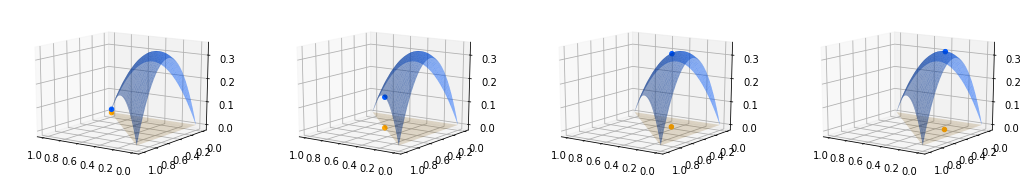

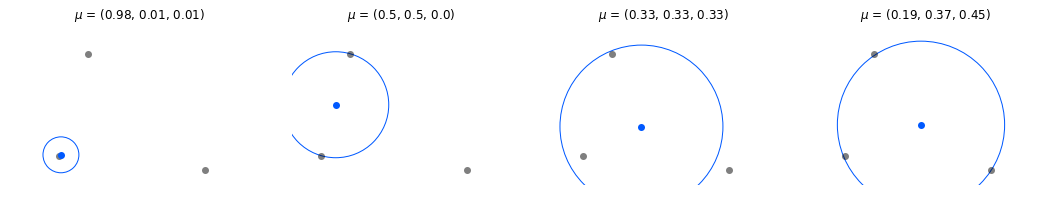

In [8]:
three_points = np.array([[0.2, 0.4, 1.2],
                         [0.2, 0.9, 0.1]])

X      = three_points
XtX, Z = init_ingredients(X)
mus    = np.array([[0.98, 0.01, 0.01], [0.5, 0.5, 0], [1/3, 1/3, 1/3], [0.186, 0.367, 0.447]])
Ls     = values_over_simplex(partial(lagrangian_dual, XtX, Z))

axs = init_plots_3D(len(mus), azim=125, elev=15)
for a, mu in zip(axs, mus):
    plot_flat_simplex(a)
    plot_over_simplex(a, Ls)
    plot_point_over_simplex(a, [mu[0], mu[1], lagrangian_dual(XtX, Z, mu)]) 
done_plots()

axs = init_plots(len(mus), lims=[0, 1.5, 0, 1.1])
for a, mu in zip(axs, mus):
    a.set_title('$\mu$ = ({})'.format(', '.join(['{:.2}'.format(m) for m in mu])))
    plot_points(a, X)
    plot_circle(a, center(X, mu), radius(XtX, Z, mu))
done_plots()

The search for a minimum enclosing ball around three points is dual to the search for weights $\mu = (\mu_1, \mu_2, \mu_3)$ that maximize $\mathcal{D}(\mu) = \mu^T \mathbf{z} - \mu^T X^T X \mu$. 

The two horizontal directions in the first row of plots correspond to $\mu_1$ and $\mu_2$. Since $\mu_3 \equiv 1 - \mu_1 - \mu_2$ we do not need to show $\mu_3$ explicitly and can use the vertical direction for the value of $\mathcal{D}$. The plot shows the concave shape of $\mathcal{D}$.

Comparing the two rows of plots the relation between $\mu$, $\mathbf{c}$, and $r$ becomes clear. The center $\mathbf{c}$ is the weighted mean of the points $ \mathbf{x}_1, \mathbf{x}_2, \mathbf{x}_3 $ as we defined $\mathbf{c} = X^T \mu = \mu_1 \mathbf{x}_1 + \mu_2 \mathbf{x}_2 + \mu_3 \mathbf{x}_3 $. In the derivation of the formula for the radius, we already assumed an optimal choice of $\mu$, so that it only leads to a minimum enclosing ball of the points when we found an optimal $\mathbf{c}$. We defined the square of the radius $r^2$ to be the weighted mean of the squared length of the points minus the squared length of the center. $r^2 = \mu^T \mathbf{z} - \mathbf{c}^T\mathbf{c} =  \mu_1 \mathbf{x}_1^T\mathbf{x}_1 + \mu_2 \mathbf{x}_2^T\mathbf{x}_2 + \mu_3 \mathbf{x}_3^T\mathbf{x}_3 - \mathbf{c}^T\mathbf{c} = \mu_1 \|\mathbf{x}_1\|^2 + \mu_2 \|\mathbf{x}_2\|^2 + \mu_3 \|\mathbf{x}_3\|^2 - \|\mathbf{c}\|^2$. 

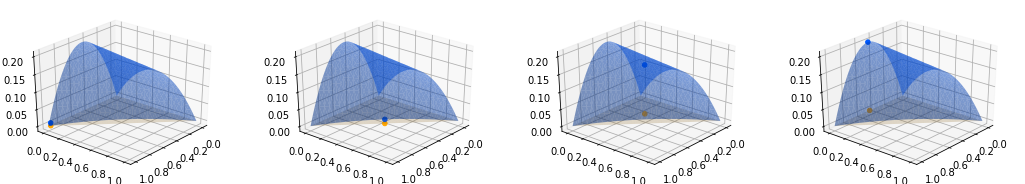

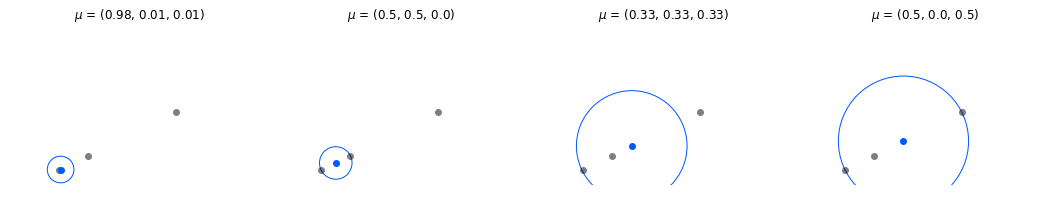

In [9]:
three_points_in_a_line = np.array([[0.2, 0.4, 1.0],
                                   [0.1, 0.2, 0.5]])

X      = three_points_in_a_line
XtX, Z = init_ingredients(X)
mus[3] = [0.5, 0.0, 0.5]
Ls     = values_over_simplex(partial(lagrangian_dual, XtX, Z))

axs = init_plots_3D(len(mus), azim=40, elev=30)
for a, mu in zip(axs, mus):
    plot_flat_simplex(a)
    plot_over_simplex(a, Ls)
    plot_point_over_simplex(a, [mu[0], mu[1], lagrangian_dual(XtX, Z, mu)]) 
done_plots()

axs = init_plots(len(mus), lims=[0, 1.5, 0, 1.1])
for a, mu in zip(axs, mus):
    a.set_title('$\mu$ = ({})'.format(', '.join(['{:.2}'.format(m) for m in mu])))
    plot_points(a, X)
    plot_circle(a, center(X, mu), radius(XtX, Z, mu))
done_plots()

## Frank-Wolfe Optimization

In [10]:
def frank_wolfe_optimization(n, gradient_at, tmax=1000, show=lambda state, t, eta, grd, s, mu: None):
    
    I  = np.identity(n)
    mu = np.ones(n) / n

    for t in range(tmax):
        
        eta = 2. / (t + 2)
        
        grd = gradient_at(mu)
        s   = np.argmin(grd)
        
        mu += eta * (I[s] - mu)                                ; show('updated', t, eta, grd, s, mu)

    return mu

## Progress Visualization Utilities

In [11]:
def show_updated_ball(n_cols, lims, X, XtX, Z, 
                      state, t, eta, grd, s, mu):
    
    global col, axs, prev_c, prev_r
    
    if t == 0: col = 0; prev_c = None; prev_r = None
    if col == 0: axs = init_plots(n_cols, lims)
    a = axs[col]
    
    c = center(X, mu)
    r = radius(XtX, Z, mu)
    d = distance(X, Z, c, r)
    
    a.set_title('{}) $\eta$={:.3}, s={}, d={:.3}'.format(t+1, eta, s, d))
    if prev_r: plot_circle(a, prev_c, prev_r, alpha=alpha_old)
    plot_points(a, X)
    plot_reference_point(a, X[:, s])
    plot_circle(a, c, r)

    prev_c, prev_r = c, r
    col += 1
    if col == n_cols: 
        done_plots(); col = 0    

In [12]:
def show_updated_lagrangian_dual(n_cols, X, XtX, Z, D, 
                                 state, t, eta, grd, s, mu):
    global col, axs, mus
    assert len(X[0]) == 3, 'We can only visualize the Lagrangian for three points.'
    
    if t == 0: col = 0; mus = np.array([mu])
    if col == 0: axs = init_plots_3D(n_cols, azim=125, elev=15)
    a = axs[col]
    
    mus = np.append(mus, [mu], axis=0)
    L = lagrangian_dual(XtX, Z, mu)
    
    a.set_title('{}) $\eta$={:.3}, s={}, $L$={:.3}'.format(t+1, eta, s, L))
    plot_flat_simplex(a)
    plot_over_simplex(a, D)
    plot_flat_trace(a, mus)
    plot_point_over_simplex(a, [mu[0], mu[1], L]) 
    
    col += 1
    if col == n_cols: 
        done_plots(); col = 0    

### Progress for the Three Points Example

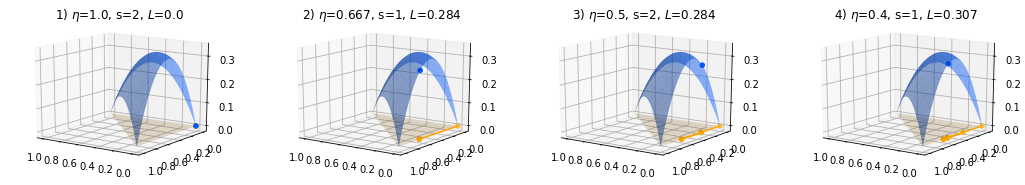

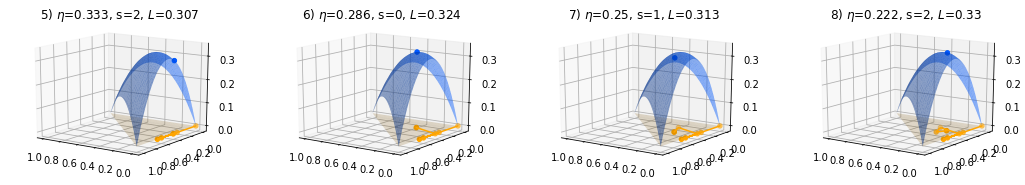

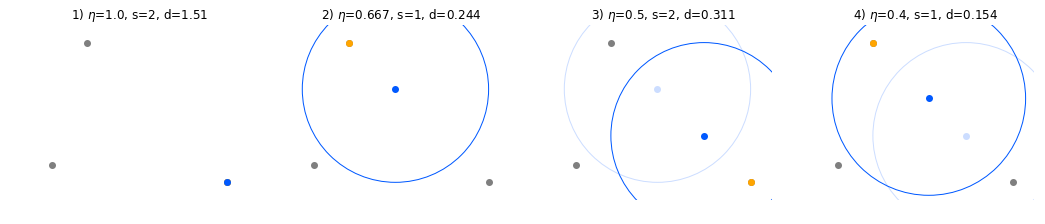

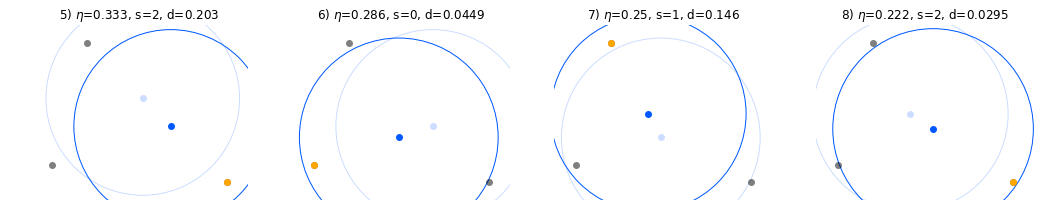

Center is  [0.74444444 0.40555556]  and radius is  0.5741606864172786


In [13]:
X      = three_points
XtX, Z = init_ingredients(X)

grad = partial(neg_lagrangian_dual_gradient, XtX, Z)

show = partial(show_updated_lagrangian_dual, 4, X, XtX, Z, values_over_simplex(partial(lagrangian_dual, XtX, Z)))
mu   = frank_wolfe_optimization(X.shape[1], grad, tmax=8, show=show)

show = partial(show_updated_ball, 4, find_limits(X), X, XtX, Z)
mu   = frank_wolfe_optimization(X.shape[1], grad, tmax=8, show=show)

print('Center is ', center(X, mu), ' and radius is ', radius(XtX, Z, mu))

As long as we only consider three points we can visualize (a flat projection) of the simplex of possible $\mu$ values and the corresponding values of $\mathcal{D}$. 

The two colors have different meanings in the different plots. In the 3d plots we use orange for $\mu$ and blue for $\mathcal{D}$. In the other plots we use blue for the circle with center $\mathbf{c}$ and radius $r$. We highlight with orange the point into whose direction the algorithm shifted the center in this step. If you compare it with the previous circle, you see that it is the point that is farthest from the previous circle.

In our simple implementation of Frank Wolfe, we do not control the step width. As a result you see the weights oscilating between two points in the beginning. Only in step 6 we make a move towards the third point, when both other points are closer to the circle than the third point.

For more points, we can easily draw the points and the circle, but we would need to draw a n-simplex in the $\mathbb{R}^{n+1}$ or projected into the $\mathbb{R}^n$ for n points.

You could use $\mu_i$ as the alpha for the point $\mathbf{x}_i$. Try it if you are courious.

## Further Examples

In [14]:
def generate_noisy_half_moon(n, r=1., noise=0.1):
    t = np.linspace(np.pi/4, np.pi + np.pi/4, n)
    X = np.vstack((r * np.cos(t) + noise * np.random.randn(n),
                   r * np.sin(t) + noise * np.random.randn(n)))
    return X

def generate_gaussian_blob(n, mu=np.zeros(2), S=np.identity(2)):
    x, y = rnd.multivariate_normal(mu, S, n).T
    return np.vstack((x, y))

def add_point(X, p):
    return np.append(X, p[:, np.newaxis], axis=1)

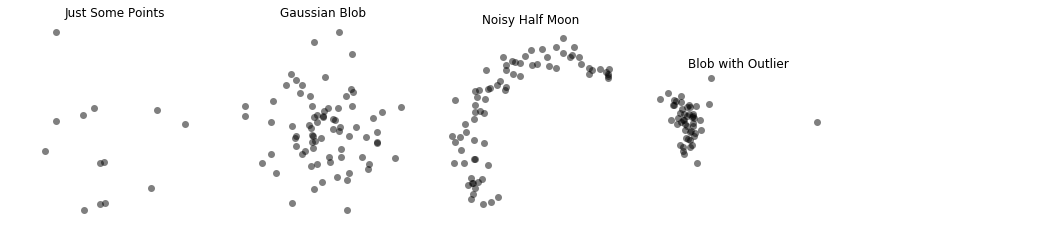

In [15]:
just_some_points  = generate_gaussian_blob(13)
gaussian_blob     = generate_gaussian_blob(75)
noisy_half_moon   = generate_noisy_half_moon(75)
blob_with_outlier = generate_gaussian_blob(50, S=np.array([[0.4, -0.05], [-0.05, 1.4]]))
blob_with_outlier = add_point(blob_with_outlier, np.array([9., 0.]))

axs = init_plots(5)
for a, points, title in zip(axs, [just_some_points, gaussian_blob, noisy_half_moon, blob_with_outlier],
                                 ['Just Some Points', 'Gaussian Blob', 'Noisy Half Moon', 'Blob with Outlier']):
    a.set_title(title)
    plot_points(a, points)
done_plots()

### Just Some Points

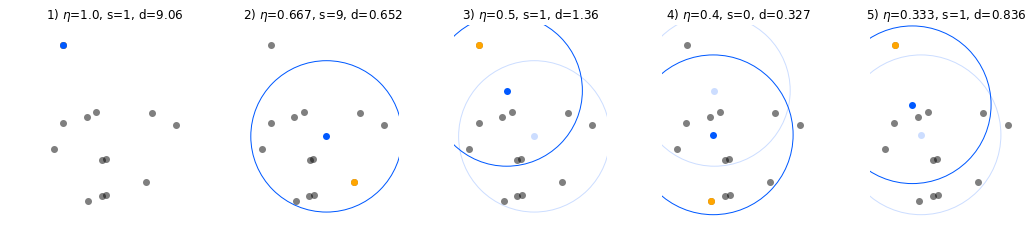

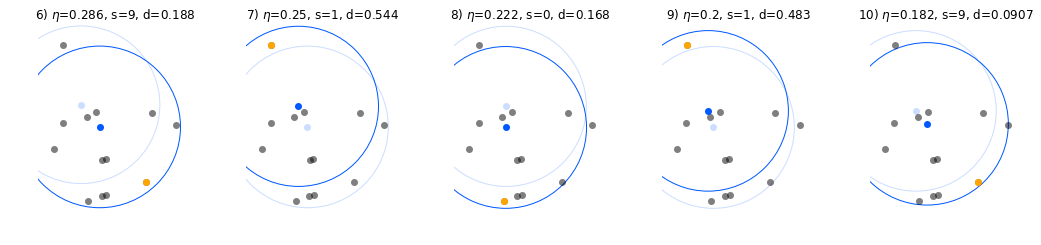

Center is  [-0.31441937  0.62489858]  and radius is  1.6897745093430572


In [16]:
X      = just_some_points
XtX, Z = init_ingredients(X)

grad = partial(neg_lagrangian_dual_gradient, XtX, Z)
show = partial(show_updated_ball, 5, find_limits(X), X, XtX, Z)

mu   = frank_wolfe_optimization(X.shape[1], grad, tmax=10, show=show)

print('Center is ', center(X, mu), ' and radius is ', radius(XtX, Z, mu))

### Gaussian Blob

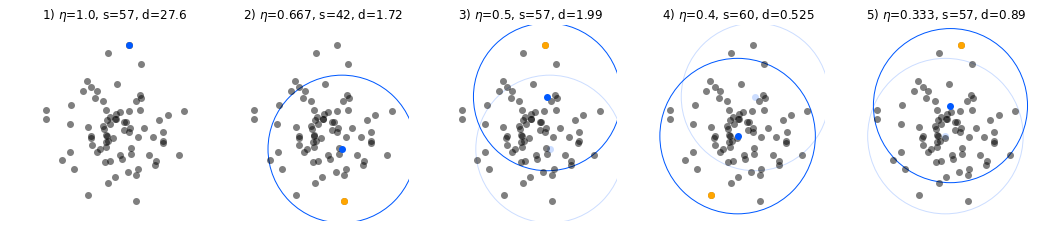

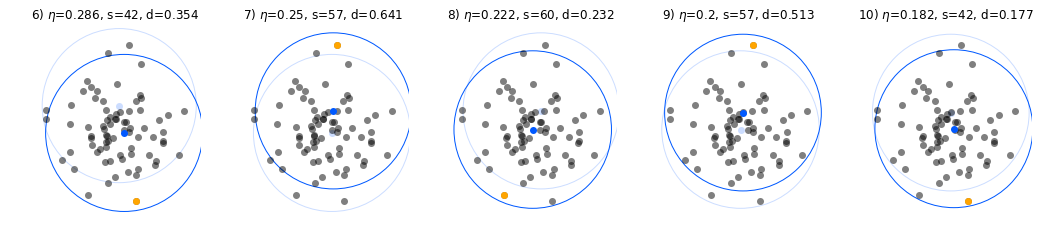

Center is  [ 0.31129261 -0.07018981]  and radius is  2.6185456160649947


In [17]:
X      = gaussian_blob
XtX, Z = init_ingredients(X)

grad = partial(neg_lagrangian_dual_gradient, XtX, Z)
show = partial(show_updated_ball, 5, find_limits(X), X, XtX, Z)

mu   = frank_wolfe_optimization(X.shape[1], grad, tmax=10, show=show)

print('Center is ', center(X, mu), ' and radius is ', radius(XtX, Z, mu))

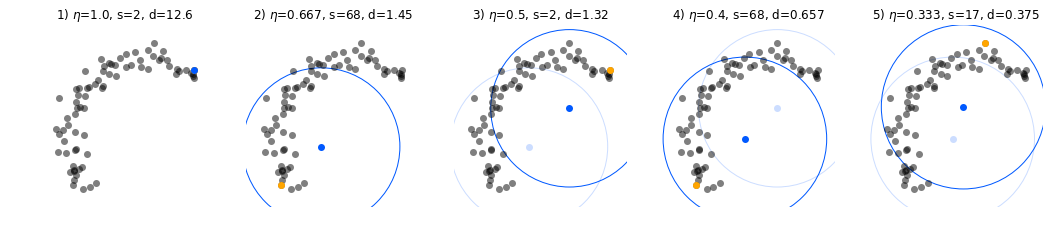

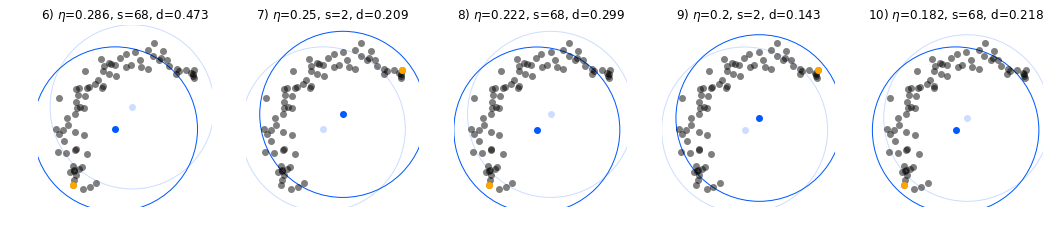

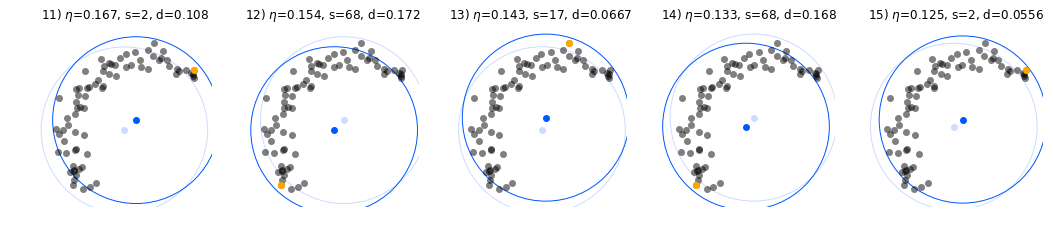

Center is  [-0.13353149  0.21879144]  and radius is  1.117551252083118


In [18]:
X      = noisy_half_moon
XtX, Z = init_ingredients(X)

grad = partial(neg_lagrangian_dual_gradient, XtX, Z)
show = partial(show_updated_ball, 5, find_limits(X), X, XtX, Z)

mu   = frank_wolfe_optimization(X.shape[1], grad, tmax=15, show=show)

print('Center is ', center(X, mu), ' and radius is ', radius(XtX, Z, mu))

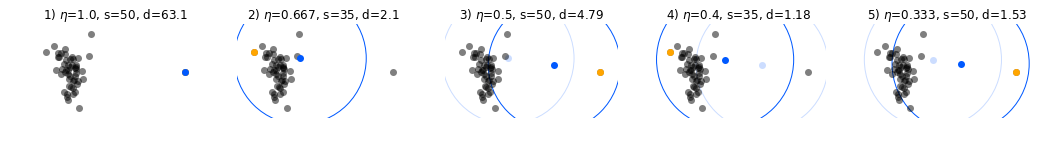

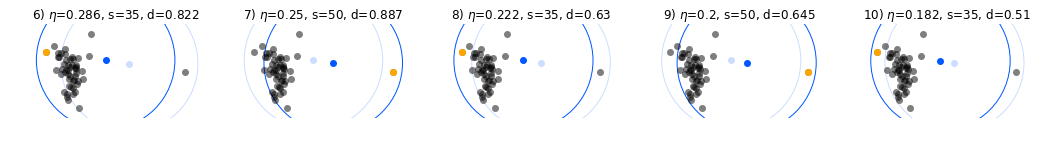

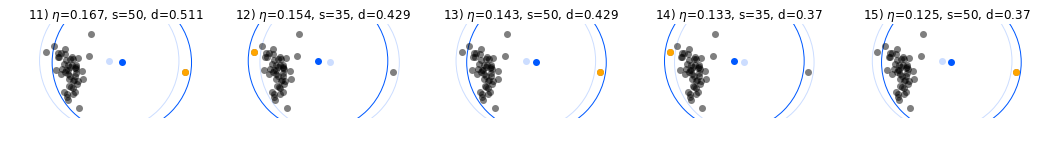

Center is  [4.04108811 0.71688388]  and radius is  5.356409209567266


In [19]:
X      = blob_with_outlier
XtX, Z = init_ingredients(X)

grad = partial(neg_lagrangian_dual_gradient, XtX, Z)
show = partial(show_updated_ball, 5, find_limits(X), X, XtX, Z)

mu   = frank_wolfe_optimization(X.shape[1], grad, tmax=15, show=show)

print('Center is ', center(X, mu), ' and radius is ', radius(XtX, Z, mu))

## There is Convergency

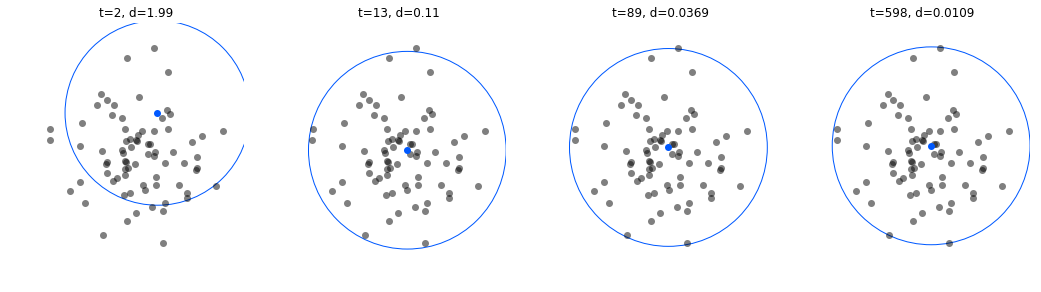

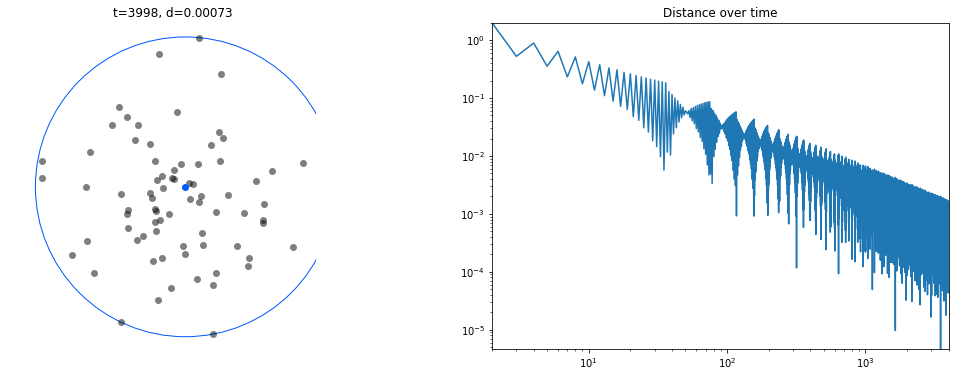

In [20]:
X      = gaussian_blob
XtX, Z = init_ingredients(X)
grad   = partial(neg_lagrangian_dual_gradient, XtX, Z)

tmax = 4000
centers   = np.zeros((tmax, 2))
radii     = np.zeros(tmax)
distances = np.zeros(tmax)

def remember_distances(state, t, eta, grd, s, mu):
    global centers, radii, distances
    c = center(X, mu)
    r = radius(XtX, Z, mu)
    d = distance(X, Z, c, r)
    centers[t], radii[t], distances[t] = c, r, d


mu = frank_wolfe_optimization(X.shape[1], grad, tmax=tmax, show=remember_distances)


ts = np.geomspace(2, tmax-1, 5, dtype=int)

axs = init_plots(len(ts[:-1]), find_limits(X))
for a, t in zip(axs, ts[:-1]):
    a.set_title('t={}, d={:.3}'.format(t, distances[t]))
    plot_points(a, X)
    plot_circle(a, centers[t], radii[t])
done_plots()

axs = init_plots(2)

axs[0].set_title('t={}, d={:.3}'.format(ts[-1], distances[-1]))
plot_points(axs[0], X)
plot_circle(axs[0], centers[-1], radii[-1])

axs[1].set_title('Distance over time')
axs[1].set_xlim(ts[0], tmax)
axs[1].set_ylim(distances.min(), distances[ts[0]:ts[0]+5].max())
axs[1].set_aspect(aspect='auto')
axs[1].set_axis_on()
axs[1].loglog(range(ts[0], tmax), distances[ts[0]:])

done_plots()

<table style="width:100%">
  <tr>
      <td colspan="1" style="text-align:left;background-color:#0071BD;color:white">
        <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">
            <img alt="Creative Commons License" style="border-width:0;float:left;padding-right:10pt"
                 src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" />
        </a>
        &copy; C. Bauckhage and D. Speicher<br/>
        Licensed under a 
        <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/" style="color:white">
            CC BY-NC 4.0
        </a>.
      </td>
      <td colspan="2" style="text-align:left;background-color:#66A5D1">
          <b>Acknowledgments:</b>
          This material was prepared within the project
          <a href="http://www.b-it-center.de/b-it-programmes/teaching-material/p3ml/" style="color:black">
              P3ML
          </a> 
          which is funded by the Ministry of Education and Research of Germany (BMBF)
          under grant number 01/S17064. The authors gratefully acknowledge this support.
      </td>
  </tr>
</table>